# **Imports/External Libraries**
The library that I decided to use for the natural language processing is fast.ai by Jeremy Howard because it simplifies training fast and accurate neural nets using modern best practices.

## About fastai
fastai is a deep learning library which provides practitioners with high-level components that can quickly and easily provide state-of-the-art results in standard deep learning domains, and provides researchers with low-level components that can be mixed and matched to build new approaches. It aims to do both things without substantial compromises in ease of use, flexibility, or performance. This is possible thanks to a carefully layered architecture, which expresses common underlying patterns of many deep learning and data processing techniques in terms of decoupled abstractions. These abstractions can be expressed concisely and clearly by leveraging the dynamism of the underlying Python language and the flexibility of the PyTorch library. fastai includes:

- A new type dispatch system for Python along with a semantic type hierarchy for tensors
- A GPU-optimized computer vision library which can be extended in pure Python
An optimizer which refactors out the common functionality of modern optimizers into two basic pieces, allowing optimization algorithms to be implemented in 4–5 lines of code
- A novel 2-way callback system that can access any part of the data, model, or optimizer and change it at any point during training
- A new data block API

The fastai library is organized around two main design goals: to be approachable and rapidly productive, while also being deeply hackable and configurable. It is built on top of a hierarchy of lower-level APIs which provide composable building blocks. This way, a user wanting to rewrite part of the high-level API or add particular behavior to suit their needs does not have to learn how to use the lowest level.

In [1]:
# If any of imports do not work, uncomment the following:
# ! pip install fastai2
# ! pip install utils

from fastai.text import *
from utils import *

## Read in Information about Datasets with Pandas
Many popular data science Python libraries are dependencies of fast.ai such as Pytorch, Pandas, Numpy, and more. This is the reason why pandas is not explicitly imported.



In [3]:
path = "/content"
main = pd.read_csv(path + '/training_data.csv')


# **Data Preprocessing**
Only 20% of the data was trained on because of several factors such as the amount of time it would take and the cost associated with running it in an online environment. The data was read with Pandas and turned into a Pandas Dataframe for training. The training/testing dataframes were split from the original training_data.csv data in a 90%/10% split respectively. I decided to use this figure for splitting the data because of how large the dataset was and I wanted the model to train on more words to build up its vocabulary.


In [4]:
# Getting an idea of how large the training_data.csv dataset is
print(main.shape)

mat = []
for i in range(20000):
  tmp = []
  tmp.append(main['Text'][i])
  if main['Sentiment'][i] == 1:
    tmp.append("1")
  else:
    tmp.append("0")
  mat.append(tmp)

train_mat = []
for i in range(20001, 200000):
  tmp = []
  tmp.append(main['Text'][i])
  if main['Sentiment'][i] == 1:
    tmp.append("1")
  else:
    tmp.append("0")
  train_mat.append(tmp)

train = pd.DataFrame(train_mat, columns=['Text','Sentiment'])
print(train.head())

(1000000, 4)
                                                Text Sentiment
0  I *heart* filling up @dennisschaub desk   1 it...         1
1  #SocioMat - people create prettier, younger an...         1
2                no way i dont want the tour to end          0
3  @HemalRadia Hi Amazing Brother! Sending Limitl...         1
4                   @flockmaster they are chocolate          1
                                                Text Sentiment
0       @XaviAceto Yay! I look forward to a review.          1
1  playing with his new mac pro...and slightly di...         0
2  Ugh @TreyDerbes now I have that song in my hea...         1
3                                      Dyed my hair          1
4  @d33pak well if you aredieting i shouldnt tell...         1


In [31]:
valid = pd.read_csv(path + '/contestant_judgment.csv')


## Data Tokenization/Formatting
The previous train dataframe is now being formatted into a native fastai dataframe for machine learning. The train dataframe is split one again into an 80%/20% split to create a validation dataset, which is critical to prevent overfitting. 

```
data_clas = (TextList.from_df(train, cols='Text', vocab=data.vocab)
             .split_by_rand_pct(0.2)
             .label_from_df(cols= 'Sentiment')
             .add_test(valid_datalist)
             .databunch(bs=64))          
```
The code above tokenizes the words in the sentence as well, which is why the ".show_batch()" function spits out a bunch of gibberish. Some of the special tokens that are present in the output include the following:

- UNK (xxunk) is for an unknown word (one that isn’t present in the current vocabulary)
- BOS (xxbos) represents the beginning of a text in your dataset
- FLD (xxfld) is used if you set mark_fields=True in your TokenizeProcessor 1 to separate the different fields of texts (if your texts are loaded from several columns in a dataframe)
- TK_MAJ (xxmaj) is used to indicate the next word begins with a capital in the original text
- TK_UP (xxup) is used to indicate the next word is written in all caps in the original text
- TK_REP (xxrep) is used to indicate the next character is repeated n times in the original text (usage xxrep n {char})
- TK_WREP (xxwrep) is used to indicate the next word is repeated n times in the original text (usage xxwrep n {word})



In [5]:
data = (TextList.from_df(train, cols='Text')
                .split_by_rand_pct(0.2)
                .label_for_lm()  
                .databunch(bs=256))
type(data)

fastai.text.data.TextLMDataBunch

In [6]:
# If you are getting any CUDA Memory Allocation errors, this may clear up some space for you
import torch
gc.collect()

0

# **Training**
## About the Model
The ML model that was chosen is called an ASGD Weight-Dropped LSTM (AWD-LSTM) which is a type of recurrent neural network that employs DropConnect for regularization, as well as NT-ASGD for optimization - non-monotonically triggered averaged SGD - which returns an average of last iterations of weights. Additional regularization techniques employed include variable length backpropagation sequences, variational dropout, embedding dropout, weight tying, independent embedding/hidden size, activation regularization and temporal activation regularization.

### TLDR 
It basically is an upgraded Long short-term memory (LSTM) model. The problem with LSTM's is that their loop connections may result in overfitting after several iterations/epochs.



Even though the accuracy is utterly pathetic at this point, continue to read this notebook because it gets significantly better later on. This is a demonstration of testing the model for text generation. The sentiment analysis is below.

In [7]:
learn = language_model_learner(data,AWD_LSTM, drop_mult=0.3)


# Fit the model based on selected learning rate
learn.fit_one_cycle(5, moms=(0.8,0.7))

# Tune a little more
learn.unfreeze()
learn.fit_one_cycle(5, 1e-3, moms=(0.8,0.7))

# Save the encoder for use in classification
learn.save_encoder('fine_tuned_enc')

epoch,train_loss,valid_loss,accuracy,time
0,5.317976,4.756107,0.192690,10:16
1,4.593024,4.389368,0.226028,10:04
2,4.400719,4.311342,0.232425,09:55
3,4.306482,4.284898,0.234936,09:54
4,4.267415,4.280719,0.235167,09:44


epoch,train_loss,valid_loss,accuracy,time
0,4.140923,4.155505,0.254215,12:14
1,4.037591,4.078052,0.263618,12:13
2,3.919131,4.046892,0.267052,12:05
3,3.803372,4.045217,0.267992,12:18
4,3.733804,4.052098,0.267892,12:10


## Sentiment Analysis
This is very similar to the text generation above; however, we provide the model the 'Sentiment' column in the training dataset. Below is the key for the tokenization again:

- UNK (xxunk) is for an unknown word (one that isn’t present in the current vocabulary)
- BOS (xxbos) represents the beginning of a text in your dataset
- FLD (xxfld) is used if you set mark_fields=True in your TokenizeProcessor 1 to separate the different fields of texts (if your texts are loaded from several columns in a dataframe)
- TK_MAJ (xxmaj) is used to indicate the next word begins with a capital in the original text
- TK_UP (xxup) is used to indicate the next word is written in all caps in the original text
- TK_REP (xxrep) is used to indicate the next character is repeated n times in the original text (usage xxrep n {char})
- TK_WREP (xxwrep) is used to indicate the next word is repeated n times in the original text (usage xxwrep n {word})

In [ ]:
valid_datalist = TextList.from_df(valid, cols='Text', vocab=data.vocab)
data_clas = (TextList.from_df(train, cols='Text', vocab=data.vocab)
             .split_by_rand_pct(0.2)
             .label_from_df(cols= 'Sentiment')
             .add_test(valid_datalist)
             .databunch(bs=256))

data_clas.show_batch()

### Training
The model is using the AWD-LSTM model once again. Even though the previous model was trained for text generation, the preset weights can help make this model more accurate because it has seen the vocabulary before through the previous model's training.

In [ ]:
learn_classifier = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)

# load the encoder saved  
learn_classifier.load_encoder('finished_model')

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


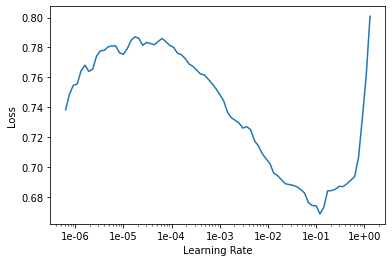

In [11]:
learn_classifier = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)

# load the encoder saved  
learn_classifier.load_encoder('fine_tuned_enc')

learn_classifier.freeze()

# select the appropriate learning rate
learn_classifier.lr_find()

# typically a good learning rate is the point where the slope is steepest
learn_classifier.recorder.plot()



In [12]:
# Fit the model based on selected learning rate
learn_classifier.fit_one_cycle(5, 1e-1, moms=(0.8,0.7))

# Tune a little more
learn_classifier.freeze_to(-2)
learn_classifier.fit_one_cycle(5, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

# Tune a little more
learn_classifier.freeze_to(-3)
learn_classifier.fit_one_cycle(5, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

# Present results
learn_classifier.show_results()

epoch,train_loss,valid_loss,accuracy,time
0,0.568960,0.491647,0.762660,10:45
1,0.558962,0.493357,0.763021,10:48
2,0.545047,0.495951,0.771160,10:52
3,0.524924,0.472400,0.773688,10:56
4,0.521123,0.466174,0.776299,10:56


epoch,train_loss,valid_loss,accuracy,time
0,0.478128,0.426319,0.803383,12:40
1,0.426163,0.399582,0.818051,12:38
2,0.417013,0.390040,0.821940,12:36
3,0.387147,0.379499,0.829106,12:38
4,0.383358,0.393323,0.830134,12:40


epoch,train_loss,valid_loss,accuracy,time
0,0.373281,0.383610,0.829134,18:33
1,0.377214,0.380011,0.829718,18:33
2,0.361378,0.372793,0.835940,18:40
3,0.278170,0.391481,0.833995,18:42
4,0.245298,0.414763,0.833495,18:38


text,target,prediction
xxbos xxunk xxmaj google xxmaj xxunk � ? � � ? � xxunk � ? � � ? � � ? � � ? xxunk � ? � � ? � � ? � xxunk � ? � xxunk � ? � xxunk � ? � � ? � � ? � � ? � xxunk � ? � � ? � � ? � xxunk � ? � xxunk,0,1
"xxbos xxmaj ice xxmaj cream xxmaj man xxmaj jus xxmaj came xxmaj by , , . i xxmaj ain ' xxmaj greedy xxmaj by xxmaj gettin ' xxmaj two * * ( xxmaj three ) * * xxmaj ice xxmaj creams xxmaj is xxmaj it , , . ? ? : \ xxmaj lol , . xxmaj they xxmaj jus xxmaj too xxmaj guhd , . ! ! !",1,1
xxbos xxunk xxunk � ? � � ? � xxunk � ? � xxunk � ? � xxunk � ? � � ? � � ? � xxunk � ? � xxunk � ? � � ? � � ? � � ? � � ? � ? � � ? � � ? � � ? � � ? � � ? � � ? �,1,1
xxbos xxunk xxup that xxup was xxup not xxup right ! xxup he xxup xxunk xxup know xxup that xxup was xxup going xxup to xxup happen xxup to xxup him ! ! xxup you xxup can xxup tell xxup how xxup he xxup just xxup left xxup so xxup fast xxup that xxup was xxup wrong xxup yo ! !,0,0
xxbos i m xxmaj so xxmaj bored ! xxmaj its xxmaj my bday xxmaj and i xxmaj have xxmaj nothin xxmaj to xxunk xxmaj off xxmaj and xxmaj every1 xxmaj else xxmaj is n't xxmaj gym xxmaj xxunk xxmaj on xxmaj my xxmaj bday xxmaj ha xxmaj this xxmaj day xxmaj could nt xxmaj get xxmaj any xxmaj worse ha,0,1


In [ ]:

preds, target = learn_classifier.get_preds(DatasetType.Test, ordered=True)
labels = np.argmax(preds, axis =1)

learn_classifier.save_encoder('finished_model')

In [ ]:
valid_datalist = TextList.from_df(valid, cols='Text', vocab=data.vocab)
data_clas = (TextList.from_df(train, cols='Text', vocab=data.vocab)
             .split_by_rand_pct(0.2)
             .label_from_df(cols= 'Sentiment')
             .add_test(valid_datalist)
             .databunch(bs=64))

data_clas.show_batch()

In [30]:
preds

tensor([[8.5877e-01, 1.4123e-01],
        [9.6818e-03, 9.9032e-01],
        [9.9999e-01, 8.0661e-06],
        ...,
        [6.1436e-02, 9.3856e-01],
        [7.7085e-01, 2.2915e-01],
        [9.9430e-01, 5.7024e-03]])

# Creating Submission


This is the section where we read in the contestant_judgement.csv file to make predictions on the data.


In [15]:
# Basic function to take in a string and return the output
# 0 -> This has a negative sentiment
# 1 -> This has a positive sentiment
def getPrediction(string):
  pred = learn_classifier.predict(string)
  if pred[2][0] > pred[2][1]:
    return 0
  else:
    return 1
  

### Tests
You can run the following pair of cells to see the output of the model.


In [16]:
if getPrediction("I'm very happy") == 1:
  print("This has a positive sentiment")
else:
  print("This has a negative sentiment")

This has a positive sentiment


In [17]:
if getPrediction("I'm very sad") == 1:
  print("This has a positive sentiment")
else:
  print("This has a negative sentiment")

This has a negative sentiment


## Writing to CSV

In [18]:
# Python library to read/write CSV's 
import csv

In [ ]:
# firstLine = True
# itr = 1
# with open("contestant_judgment.csv", "r") as csv_file:
#   csv_reader = csv.reader(csv_file)
#   with open('submission.csv', 'w') as new_file:
#     csv_writer = csv.writer(new_file)
#     for line in csv_reader:
#       print("{}/600000".format(itr))
#       if firstLine:
#         csv_writer.writerow(line + ['Sentiment'])  
#         firstLine = False
#       else:
#         pred = getPrediction(line[2])
#         csv_writer.writerow(line + [pred])
#       itr += 1
      
df = pd.read_csv(path + "/contestant_judgment.csv")
mat = pd.DataFrame(df, columns=['ID','User','Text','Sentiment'])
for i in range(600000):
  mat['Sentiment'][i] = getPrediction(mat['Text'][i])
mat.to_csv("submission.csv")
